### Import Libraries

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from modelling_functions import *
from DengueModel import *

import datetime

import warnings
warnings.simplefilter(action="ignore")

# Set all columns and rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Import Data

In [2]:
# Import the dataset
data = pd.read_csv('../datasets/data_features_with_lags.csv')

In [3]:
# Check the data
data.head()

,time,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag28,Mean Temperature (°C)_lag51,Mean Wind Speed (km/h)_lag6,Mean Wind Speed (km/h)_lag22,Mean Wind Speed (km/h)_lag47,Maximum Temperature (°C)_10,Maximum Temperature (°C)_lag10,Max Wind Speed (km/h)_lag14,Max Wind Speed (km/h)_lag41,Minimum Temperature (°C)_lag49,s_ratio,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725411,0,0,1,0,0,0,0,0,0,0,0
1,2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725367,0,0,1,0,0,0,0,0,0,0,0
2,2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725189,0,0,1,0,0,0,0,0,0,0,0
3,2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725087,0,0,1,0,0,0,0,0,0,0,0
4,2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.712189,0,0,0,1,0,0,0,0,0,0,0


In [4]:
# Check the shape of the data
data.shape

(257, 35)

In [5]:
# Look at the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   time                            257 non-null    object 
 1   dengue_cases                    257 non-null    int64  
 2   denv_1                          257 non-null    float64
 3   denv_2                          257 non-null    float64
 4   denv_3                          257 non-null    float64
 5   denv_4                          257 non-null    float64
 6   Mean Temperature (°C)           257 non-null    float64
 7   Mean Wind Speed (km/h)          257 non-null    float64
 8   Daily Rainfall Total (mm)       257 non-null    float64
 9   Maximum Temperature (°C)        257 non-null    float64
 10  Max Wind Speed (km/h)           257 non-null    float64
 11  Minimum Temperature (°C)        257 non-null    float64
 12  google_trends                   257 

### Date Processing

The date feature is currently an object time. We will be converting it into a dateTime format.

In [6]:
# Convert the date column into dateTime format
data['time'] = pd.to_datetime(data['time'])

In [7]:
# Set the time as the index
data = data.set_index('time')

In [8]:
# Check the data 
data.head()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag28,Mean Temperature (°C)_lag51,Mean Wind Speed (km/h)_lag6,Mean Wind Speed (km/h)_lag22,Mean Wind Speed (km/h)_lag47,Maximum Temperature (°C)_10,Maximum Temperature (°C)_lag10,Max Wind Speed (km/h)_lag14,Max Wind Speed (km/h)_lag41,Minimum Temperature (°C)_lag49,s_ratio,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725411,0,0,1,0,0,0,0,0,0,0,0
2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725367,0,0,1,0,0,0,0,0,0,0,0
2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725189,0,0,1,0,0,0,0,0,0,0,0
2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.725087,0,0,1,0,0,0,0,0,0,0,0
2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.712189,0,0,0,1,0,0,0,0,0,0,0


In [9]:
data.drop(columns=['denv_1', 'denv_2', 'denv_3', 'denv_4'], inplace=True)

In [10]:
# create a 1-week lag dengue cases variable for prediction
data['dengue_cases_lag_1'] = data['dengue_cases'].shift(1)
data['dengue_cases_lag_2'] = data['dengue_cases'].shift(2)
data['dengue_cases_lag_3'] = data['dengue_cases'].shift(3)

In [11]:
data.drop(columns=['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
                   'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
                  'month_12'], inplace=True)

In [12]:
data.drop(columns=['Mean Wind Speed (km/h)', 'Maximum Temperature (°C)', 'Max Wind Speed (km/h)', 'Minimum Temperature (°C)'], inplace=True)

In [13]:
# keep 2023 data as the unseen dataset for final testing
data_subset = data.loc[data.index.year < 2023, :]

In [14]:
# Lag predictors by 1 week to produce 1-week ahead forecast
columns_to_shift = list(data_subset.columns)
columns_to_shift.remove('dengue_cases')

data_subset[columns_to_shift] = data_subset[columns_to_shift].shift(1)

In [15]:
# drop any remaining NA values
data_subset.dropna(inplace=True)

### Train/Test Split

We use the last full year - 2022 - as the test year when doing validation and model choice.

In [16]:
train, test = train_test_split(data_subset, year=2021)

In [18]:
train.shape

(143, 18)

In [19]:
test.shape

(52, 18)

In [20]:
55/144

0.3819444444444444

Overall, this is about a 40% train test split:
* Train: 60% of data
* Test: 40% of data

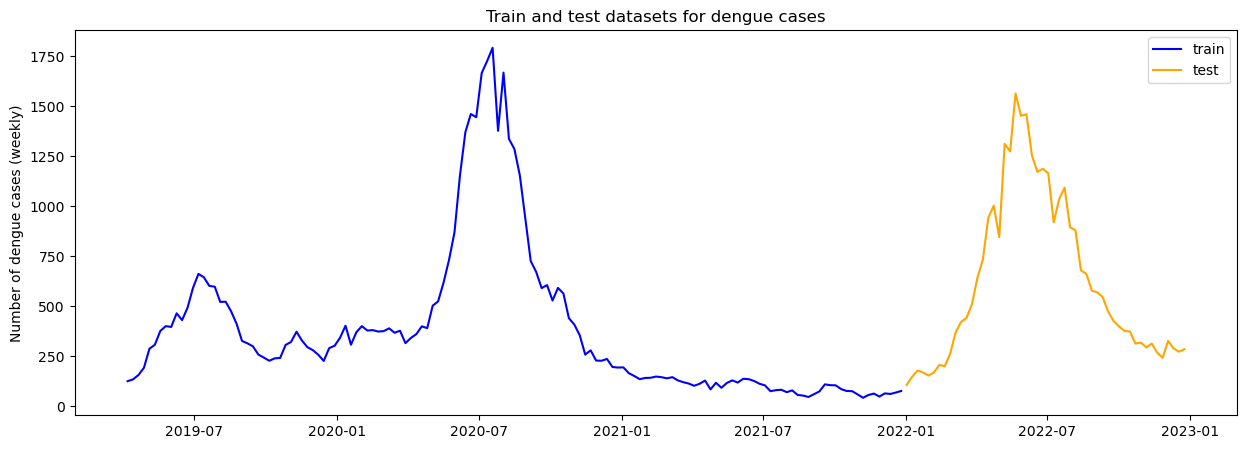

In [21]:
# Time series plot of the train and test data
train_test_plot(train, test, title='Train and test datasets for dengue cases')

## Modelling (1-week Ahead Forecasting)

### ARIMA Model (3, 1, 0)

We try out the ARIMA model and find that (3, 1, 0) works best. The RMSE is, however, still quite bad.

RMSE = 663.22

#### Stationarity Test

We will use the stationarity test to identify the $d$ parameter for the ARIMA model

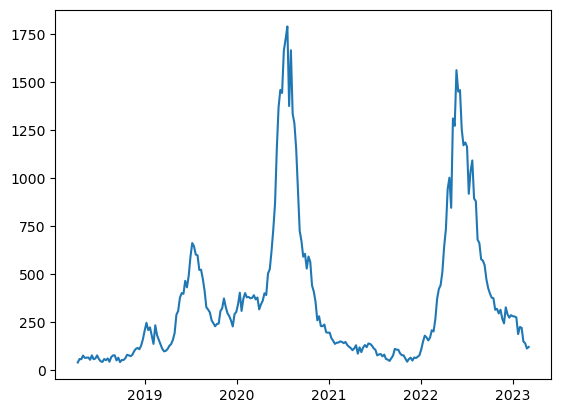

In [22]:
# Plot the data
plt.plot(data['dengue_cases']);

The time series of the dengue cases is clearly not stationary

In [23]:
# Instantiate a new dataframe for the difference information
diff = pd.DataFrame()

In [24]:
# Calculate the first difference of the dengue cases
diff['first_diff_dengue'] = data['dengue_cases'].diff()

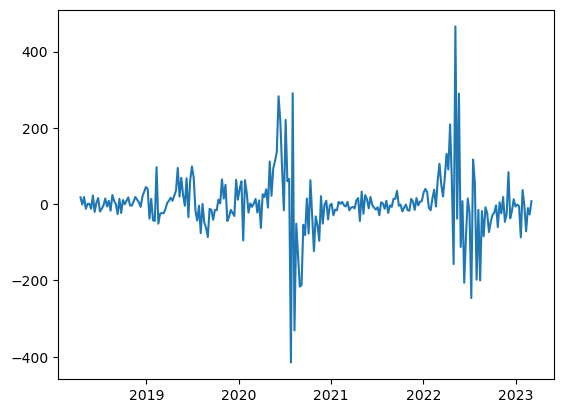

In [25]:
# Plot the first difference of the dengue cases
plt.plot(diff['first_diff_dengue']);

From the plot above, we can see that when the data is differenced once, the data is stationary. 

#### Augmented Dickey-Fuller Test

Let's also use the ADF test to test for Stationarity

In [26]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [27]:
# Run the ADF test on the original dengue data
interpret_dftest(adfuller(data['dengue_cases']))

Test Statistic   -2.549748
p-value           0.103834
dtype: float64

The p-value is above 0.05, hence this data is not stationary.

In [28]:
# Run the ADF test on the differenced dengue data
interpret_dftest(adfuller(data['dengue_cases'].diff().dropna()))

Test Statistic   -5.242290
p-value           0.000007
dtype: float64

The p-value is below 0.05 and we can conclude that the once differenced data is stationary. This is also in line with the differenced data plot. Hence, we can set the $d$ value to $1$.

#### Finding the $p$ and $q$ values

We can use a ACF and PACF plot to find the $p$ and $q$ values.

#### ACF and PACF Plot for $p$ value

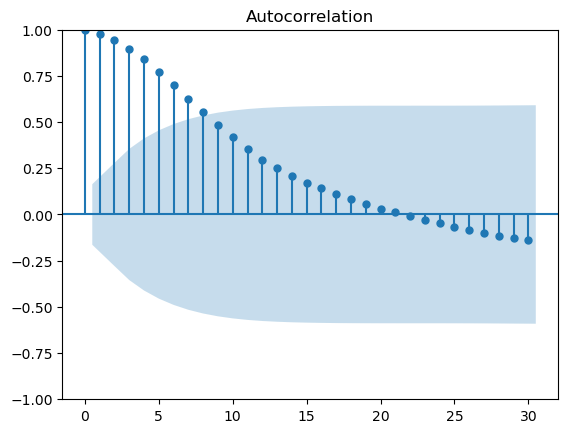

In [29]:
# Generate autocorrelation plot on training data.
plot_acf(train['dengue_cases'], lags = 30);

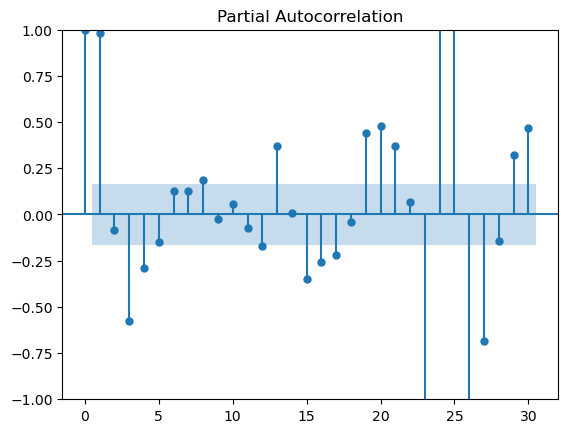

In [30]:
# Generate partial autocorrelation plot on training data.
plot_pacf(train['dengue_cases'], lags = 30);

The first lag of the ACF plot is also positive. There is also a sharp cut off in the PACF plot after the second lag. Hence, we can take the next lag of the PACF as the $p$ value and set it to $3$. 

As the $AR$ and $MA$ terms might work against each other and we were able to identify the $p$ value, we will set the $q$ value as $0$.  

#### Modeling

Next, we can fit the ARIMA model and run the prediction.

In [31]:
# Instantiate best model.
arima = ARIMA(endog=train['dengue_cases'], order=(3, 1, 0))

# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set
#preds = model.predict(start=195, end=256)
preds = model.predict(start=test.index[0], end=test.index[-1])

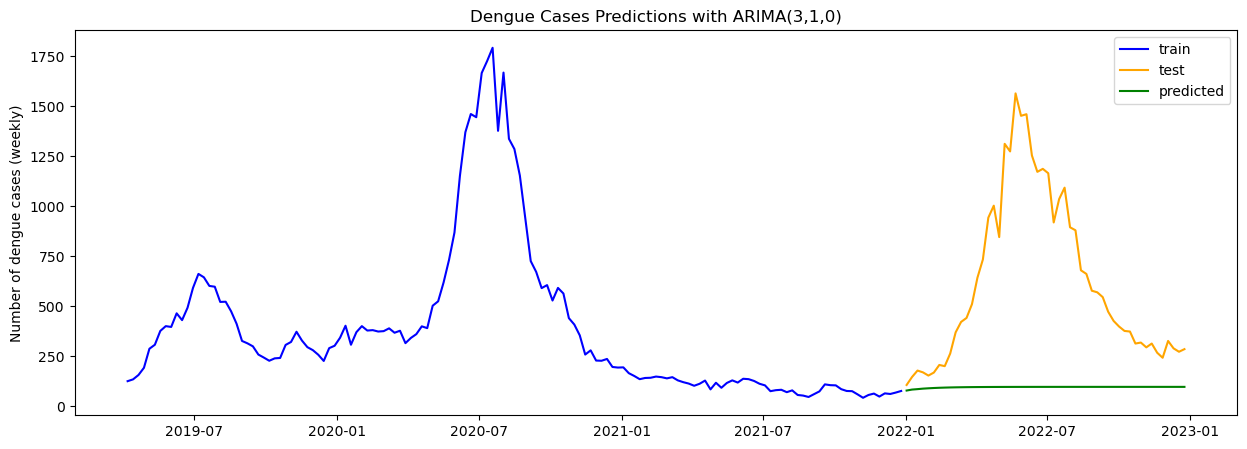

In [32]:
train_test_plot(train, test, preds, title='Dengue Cases Predictions with ARIMA(3,1,0)')

In [33]:
evaluate_model(test['dengue_cases'], preds)

RMSE: 663.2246465455045

Minimum Dengue Cases: 106
Maximum Dengue Cases: 1563
RMSE relative to minimum values in dengue cases: 6.26.
RMSE relative to maximum values in dengue cases: 0.42.


663.2246465455045

Looking at the RMSE values as well as the ratio of the mean squared error to the minimum and maximum values in the dengue cases, we can see that the model is not very good. 

#### Residual Plot

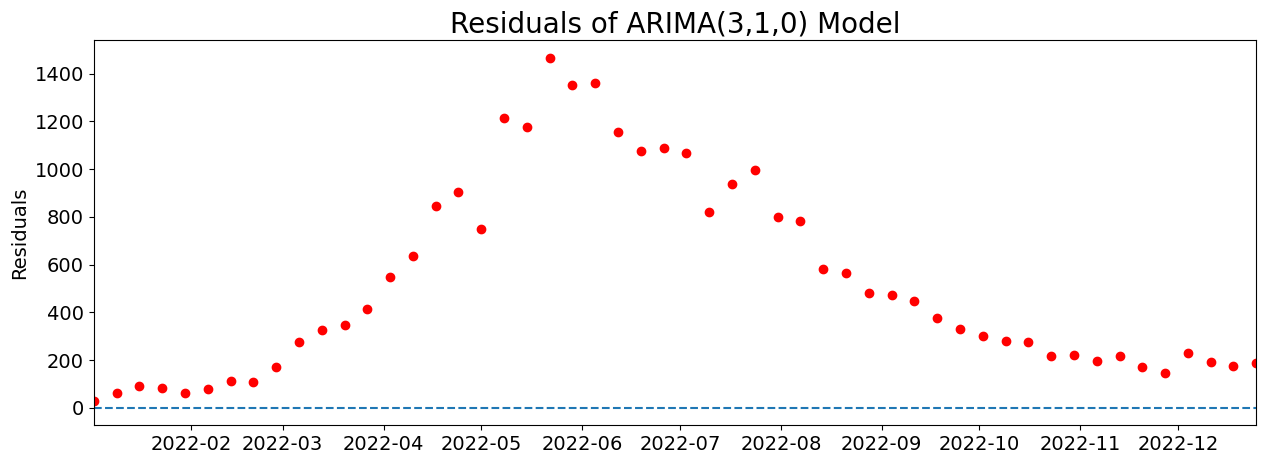

In [34]:
resid = plot_residuals(test['dengue_cases'], preds, title='Residuals of ARIMA(3,1,0) Model')

From the residual plot, we can see that the prediction is off to a high degree.

### ARIMAX

We add on predictor variables to form the ARIMAX model and find that (1, 1, 2) works best. The RMSE is, however, still bad.

RMSE = 674.63

In [35]:
# Instantiate best model.
arimax = ARIMA(endog=train['dengue_cases'], order=(1, 1, 2), 
               exog=train.drop(columns=['dengue_cases']))

# Fit ARIMA model.
model = arimax.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], end=test.index[-1], exog=test.drop(columns=['dengue_cases']))

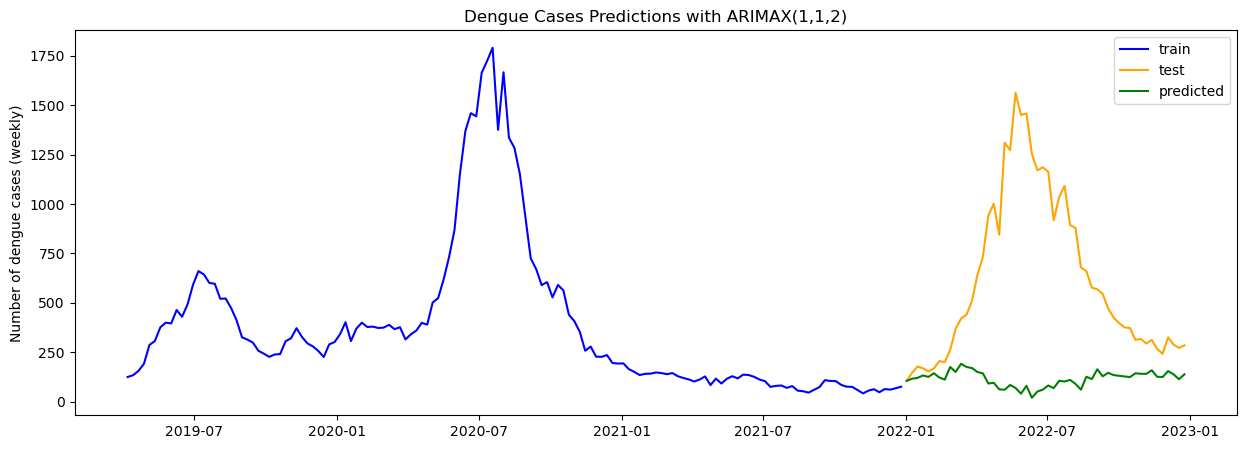

In [36]:
# plot data
train_test_plot(train, test, preds, title='Dengue Cases Predictions with ARIMAX(1,1,2)')

In [37]:
evaluate_model(test['dengue_cases'], preds)

RMSE: 665.249900453819

Minimum Dengue Cases: 106
Maximum Dengue Cases: 1563
RMSE relative to minimum values in dengue cases: 6.28.
RMSE relative to maximum values in dengue cases: 0.43.


665.249900453819

#### Residual Plot

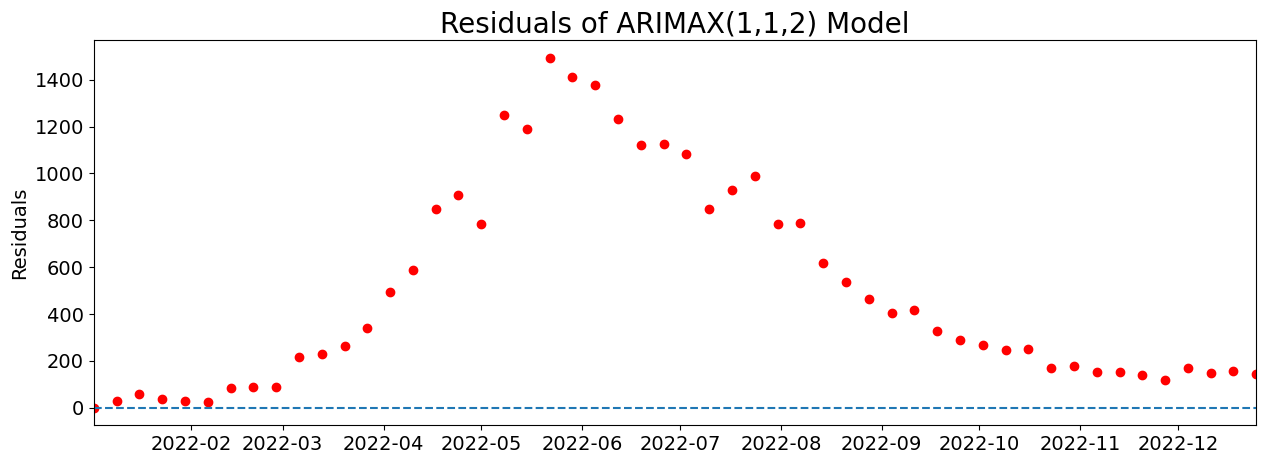

In [38]:
resid = plot_residuals(test['dengue_cases'], preds, title='Residuals of ARIMAX(1,1,2) Model')

### SARIMA Model without Exogenous Variables

We noticed some annual seasonality, hence we try out the SARIMA model first. RMSE gets better.

RMSE = 435.05

In [39]:
%%time
sarimax = SARIMAX(endog=train['dengue_cases'],
                dates=train.index,
                order=(1,1,2),
                seasonal_order=(1,1,0,51),
                enforce_stationarity=False, # speed up model fitting
                enforce_invertibility=False # speed up model fitting
               )

model = sarimax.fit(maxiter=50, method='lbfgs')

preds = model.predict(start=test.index[0], end=test.index[-1])

CPU times: total: 18 s
Wall time: 7.78 s


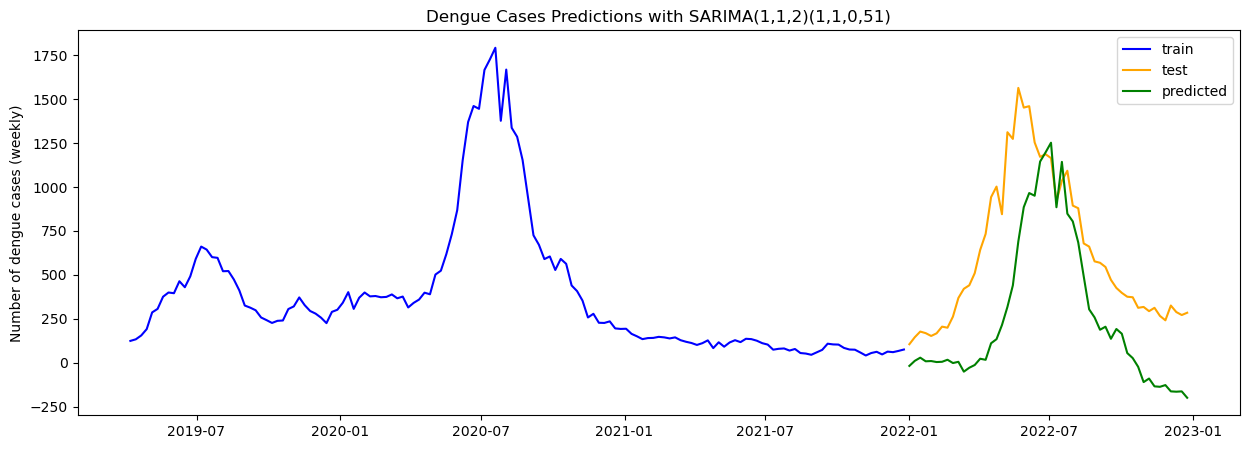

In [40]:
train_test_plot(train, test, preds, title='Dengue Cases Predictions with SARIMA(1,1,2)(1,1,0,51)')

In [41]:
evaluate_model(test['dengue_cases'], preds)

RMSE: 435.0526597001331

Minimum Dengue Cases: 106
Maximum Dengue Cases: 1563
RMSE relative to minimum values in dengue cases: 4.1.
RMSE relative to maximum values in dengue cases: 0.28.


435.0526597001331

#### Residual Plot

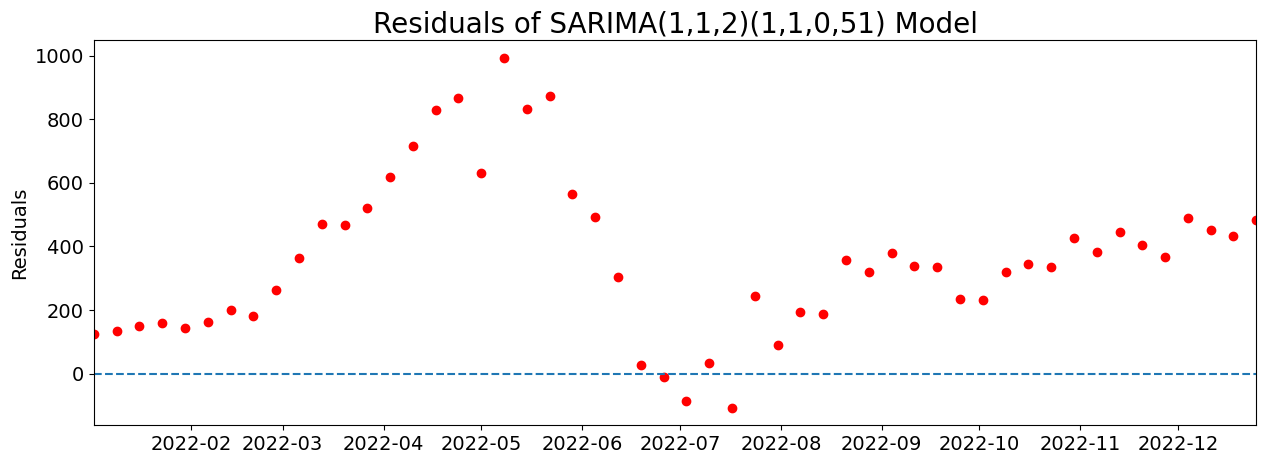

In [42]:
resid = plot_residuals(test['dengue_cases'], preds, title='Residuals of SARIMA(1,1,2)(1,1,0,51) Model')

### SARIMAX Model with Exogenous Variables

We further add predictor variables into SARIMAX model, and note that the RMSE further improves.

RMSE = 305.46

In [43]:
%%time
sarimax = SARIMAX(endog=train['dengue_cases'], exog=train.drop(columns=['dengue_cases']),
                dates=train.index,
                order=(1,1,2),
                seasonal_order=(1,1,0,48),
                enforce_stationarity=False, # speed up model fitting
                enforce_invertibility=False # speed up model fitting
               )

model = sarimax.fit(maxiter=50, method='lbfgs')

preds = model.predict(start=test.index[0], end=test.index[-1],
                           exog=test.drop(columns=['dengue_cases']))

CPU times: total: 55.8 s
Wall time: 19.2 s


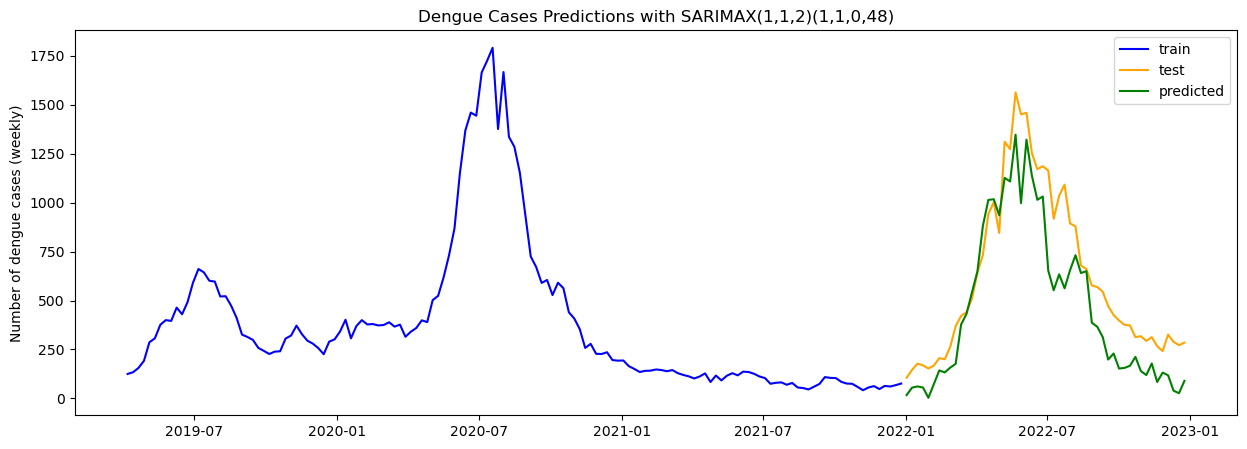

In [44]:
train_test_plot(train, test, preds, title='Dengue Cases Predictions with SARIMAX(1,1,2)(1,1,0,48)')

In [45]:
evaluate_model(test['dengue_cases'], preds)

RMSE: 206.3384062783397

Minimum Dengue Cases: 106
Maximum Dengue Cases: 1563
RMSE relative to minimum values in dengue cases: 1.95.
RMSE relative to maximum values in dengue cases: 0.13.


206.3384062783397

In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        dengue_cases   No. Observations:                  143
Model:             SARIMAX(1, 1, 2)x(1, 1, [], 48)   Log Likelihood                -239.551
Date:                             Mon, 24 Apr 2023   AIC                            523.102
Time:                                     21:28:10   BIC                            562.849
Sample:                                 04-07-2019   HQIC                           537.919
                                      - 12-26-2021                                         
Covariance Type:                               opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Mean Temperature (°C)              0.1134     46.715      0.002      0.998     -91.446      91.673
Daily Rainfall Total (mm)         -2.0944      4.278     -0.490      0.624     -10.479       6.291
google_trends                     -2.0619      4.913     -0.420      0.675     -11.691       7.567
Mean Temperature (°C)_lag28      -17.3425     30.810     -0.563      0.574     -77.730      43.045
Mean Temperature (°C)_lag51       -1.9636     33.523     -0.059      0.953     -67.667      63.740
Mean Wind Speed (km/h)_lag6      -12.9046      7.288     -1.771      0.077     -27.190       1.380
Mean Wind Speed (km/h)_lag22       8.0778      9.565      0.845      0.398     -10.670      26.825
Mean Wind Speed (km/h)_lag47      -5.8989      9.003     -0.655      0.512     -23.544      11.746
Maximum Temperature (°C)_10       -8.6699     14.609     -0.593      0.553     -37.304      19.964
Maximum Temperature (°C)_lag10    -8.6699     14.609     -0.593      0.553     -37.304      19.964
Max Wind Speed (km/h)_lag14       -0.2869      3.081     -0.093      0.926      -6.325       5.752
Max Wind Speed (km/h)_lag41       -1.0932      1.849     -0.591      0.554      -4.717       2.530
Minimum Temperature (°C)_lag49    -6.7366     17.467     -0.386      0.700     -40.971      27.498
s_ratio                          523.6994   2833.864      0.185      0.853   -5030.572    6077.971
dengue_cases_lag_1                 0.5706      0.657      0.868      0.385      -0.718       1.859
dengue_cases_lag_2                 0.0359      0.407      0.088      0.930      -0.761       0.833
dengue_cases_lag_3                 0.1489      0.442      0.337      0.736      -0.717       1.015
ar.L1                              0.5627      0.940      0.598      0.550      -1.280       2.406
ma.L1                             -0.7479      0.940     -0.796      0.426      -2.591       1.095
ma.L2                             -0.1921      0.670     -0.287      0.774      -1.505       1.121
ar.S.L48                          -0.8915      0.227     -3.920      0.000      -1.337      -0.446
sigma2                          3511.6233   1820.541      1.929      0.054     -56.572    7079.818
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.91   Prob(JB):                         0.97
Heteroskedasticity (H):               0.97   Skew:                            -0.03
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singul

#### Residual Plot

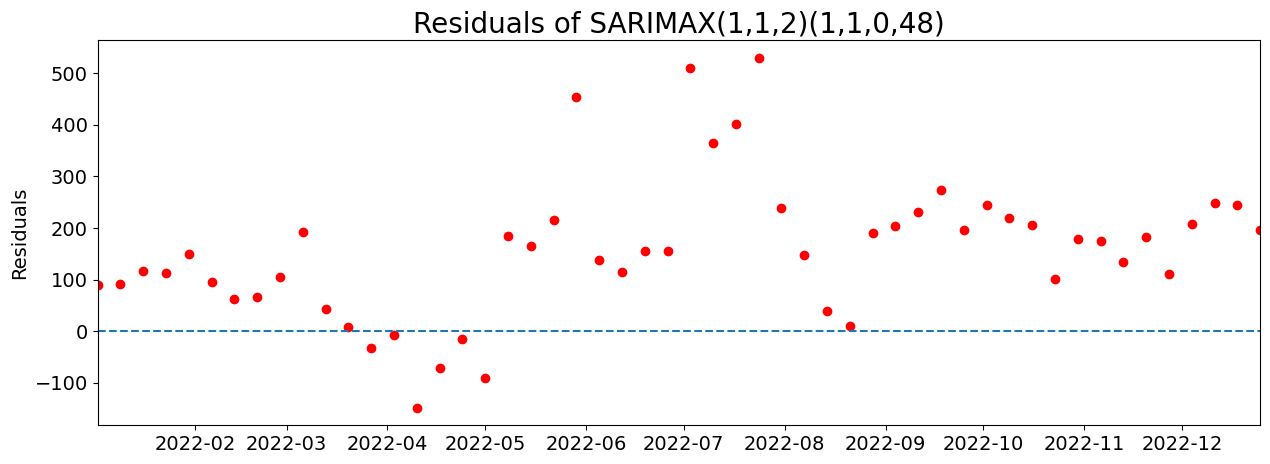

In [47]:
resid = plot_residuals(test['dengue_cases'], preds, title='Residuals of SARIMAX(1,1,2)(1,1,0,48)')

### Gradient Boosting

We try another set of models that are not time series in nature. First, gradient boosting which improves RMSE even further.

RMSE = 186.54

In [52]:
%%time 
# Define the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=100, max_depth=3)

# Define hyperparameter search grid
param_grid = {
    'n_estimators' : [50, 100, 150],
    'learning_rate' : [0.1, 0.05, 0.01],
    'max_depth' : [3, 5, 7],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'max_features' : [5, 15, 25, 30]
}

# Define gridsearch
grid_search = GridSearchCV(model, param_grid, cv=5, 
                           scoring='neg_root_mean_squared_error', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(train.drop(columns='dengue_cases'), train['dengue_cases'])

# Make predictions on the test set
preds = pd.Series(grid_search.best_estimator_.predict(test.drop(columns='dengue_cases')), index=test.index)


CPU times: total: 6.91 s
Wall time: 1min 33s


In [53]:
evaluate_model(test['dengue_cases'], preds)

RMSE: 186.54386785565822

Minimum Dengue Cases: 106
Maximum Dengue Cases: 1563
RMSE relative to minimum values in dengue cases: 1.76.
RMSE relative to maximum values in dengue cases: 0.12.


186.54386785565822

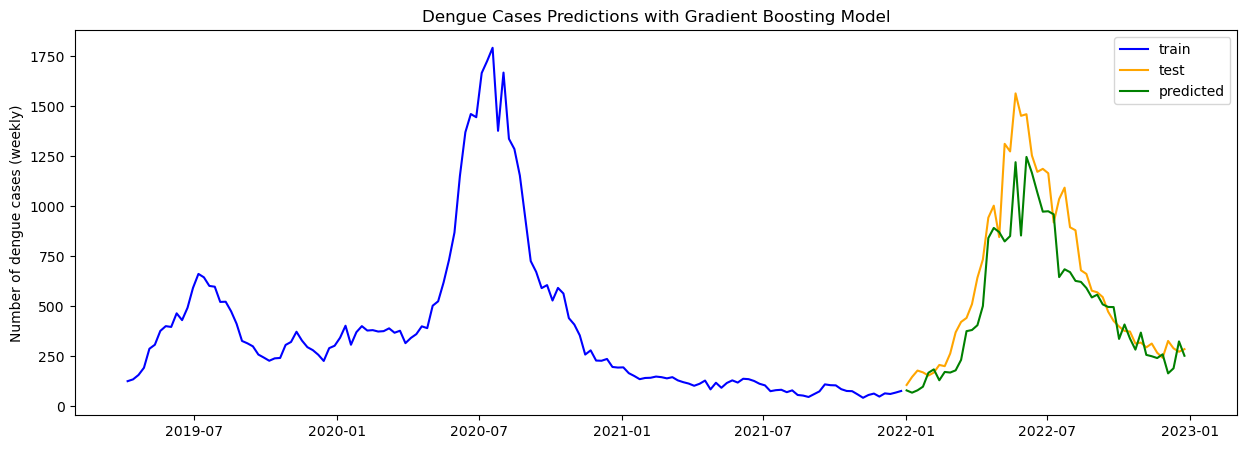

In [54]:
train_test_plot(train, test, preds, title='Dengue Cases Predictions with Gradient Boosting Model')

#### Residual Plot

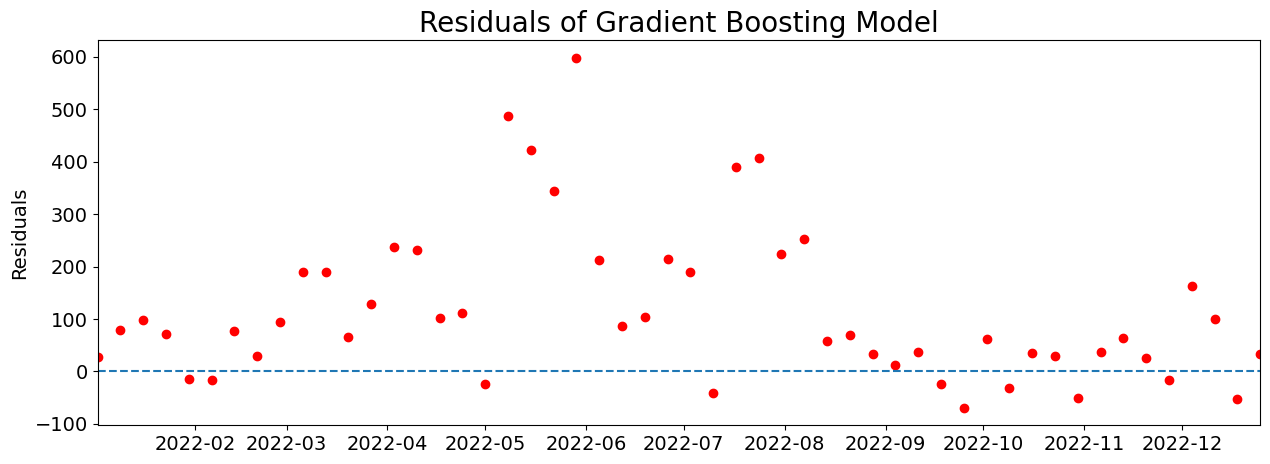

In [55]:
resid = plot_residuals(test['dengue_cases'], preds, title='Residuals of Gradient Boosting Model')

### Support Vector Machines

We also try SVM, which performs marginally worse than Gradient Boosting.

RMSE = 142.39

In [56]:
# Create the SVM model
svm = SVR(kernel='linear')

# Fit the SVM model on the training data
svm.fit(train.drop(columns='dengue_cases'), train['dengue_cases'])

# Make predictions on the test data
preds = pd.Series(svm.predict(test.drop(columns='dengue_cases')), index=test.index)


In [57]:
evaluate_model(test['dengue_cases'], preds)

RMSE: 142.38663191531705

Minimum Dengue Cases: 106
Maximum Dengue Cases: 1563
RMSE relative to minimum values in dengue cases: 1.34.
RMSE relative to maximum values in dengue cases: 0.09.


142.38663191531705

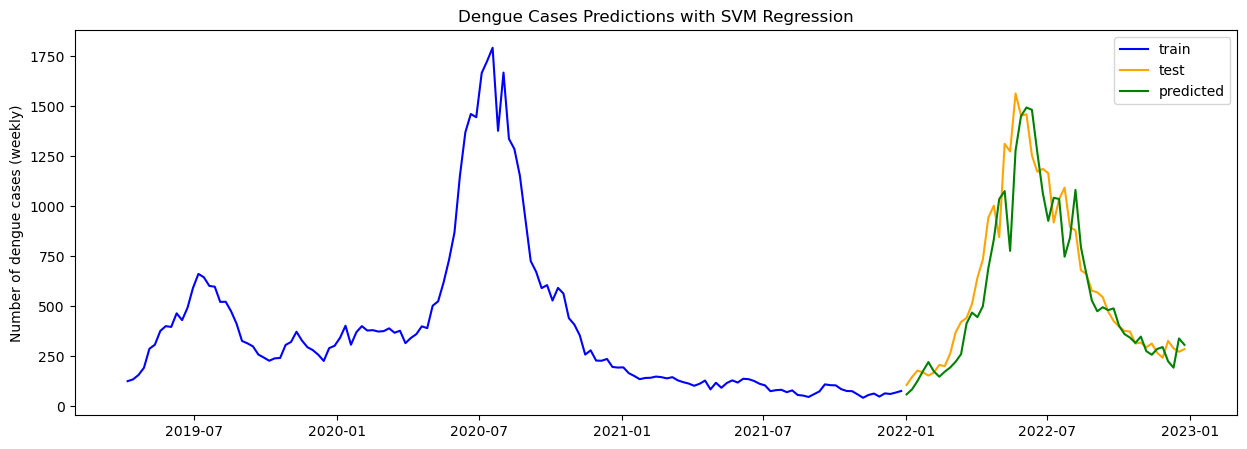

In [58]:
train_test_plot(train, test, preds, title='Dengue Cases Predictions with SVM Regression')

#### Residual Plot

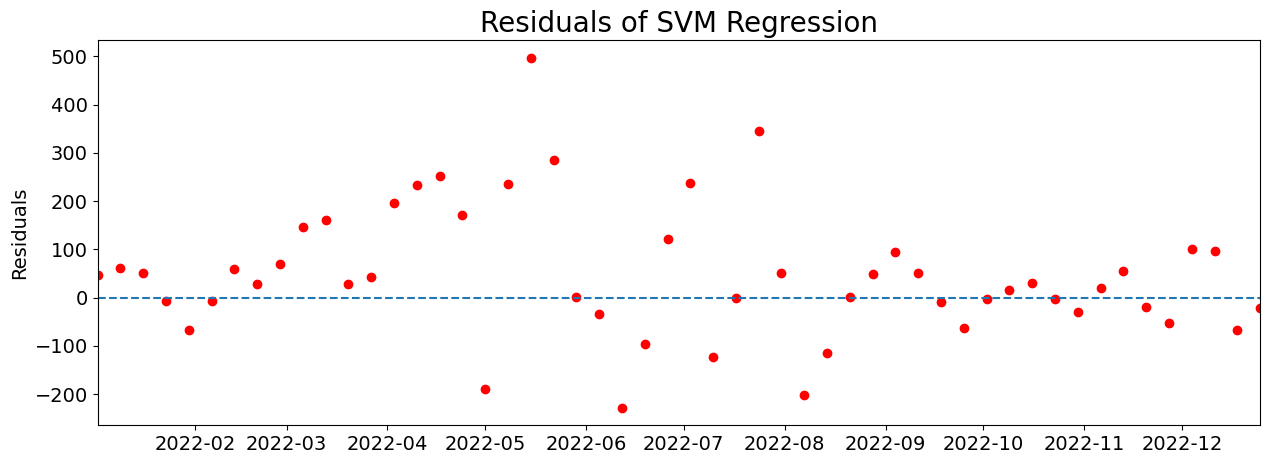

In [59]:
resid = plot_residuals(test['dengue_cases'], preds, title='Residuals of SVM Regression')

### Decision Tree and Bagging

We also try tree models. First, Bagging tree performs worse than Gradient Boosting.

RMSE = 163.57

In [63]:
# Define the base estimator
base_estimator = DecisionTreeRegressor(max_depth=3)

# Define the bagging regressor and hyperparameter serach grid
param_grid = {
    'n_estimators' : [10, 30, 50, 70, 100],
    'max_samples' : [0.1, 0.3, 0.5, 0.7, 1.0],
    'max_features' : [0.1, 0.3, 0.5, 0.7, 1.0]
}
model = BaggingRegressor(estimator=base_estimator)

# Define gridsearch
grid_search = GridSearchCV(model, param_grid, cv=5, 
                           scoring='neg_root_mean_squared_error', n_jobs=-1)

# Fit the bagging regressor on the training data
grid_search.fit(train.drop(columns='dengue_cases'), train['dengue_cases'])

# Make predictions on the test data
preds = pd.Series(grid_search.best_estimator_.predict(test.drop(columns='dengue_cases')), index=test.index)


In [64]:
evaluate_model(test['dengue_cases'], preds)

RMSE: 163.57370739225743

Minimum Dengue Cases: 106
Maximum Dengue Cases: 1563
RMSE relative to minimum values in dengue cases: 1.54.
RMSE relative to maximum values in dengue cases: 0.1.


163.57370739225743

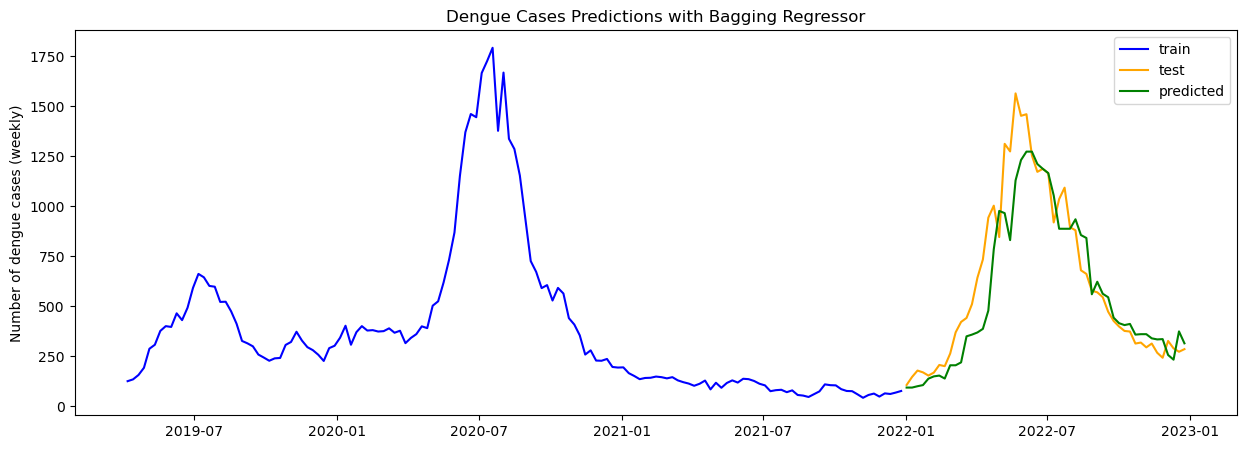

In [65]:
train_test_plot(train, test, preds, title='Dengue Cases Predictions with Bagging Regressor')

#### Residual Plot

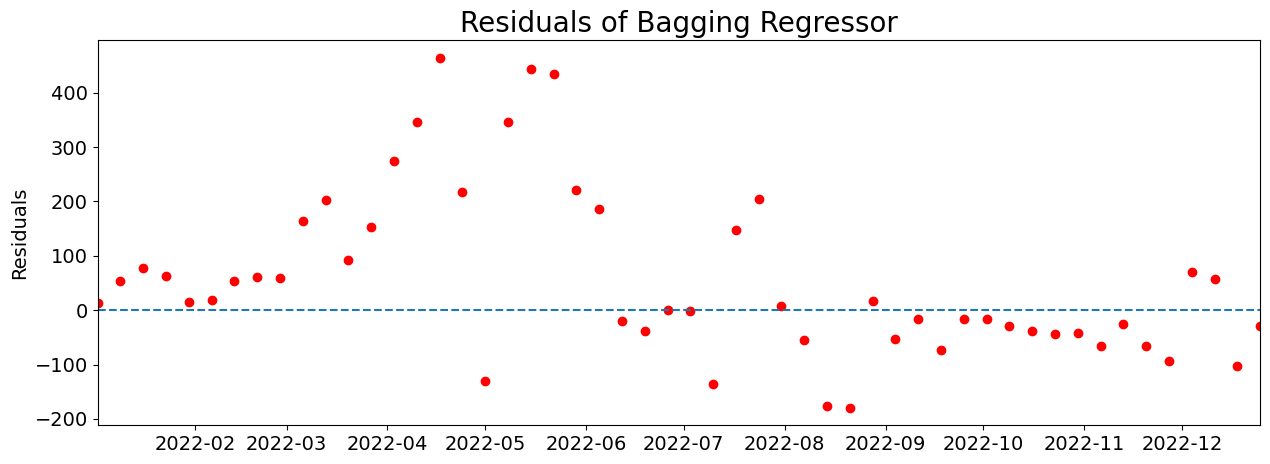

In [66]:
resid = plot_residuals(test['dengue_cases'], preds, title='Residuals of Bagging Regressor')

### Random Forest

We also try another tree model - Random Forest Regressor - which performs marginally better than Bagging Regressor but comparable to Gradiant Boosting.

RMSE = 152.89

In [60]:
# set hyparameters (best ones)
rf_params = {
    'n_estimators':1000, 
    'random_state':42
}

In [71]:
# set hyparameters for tuning
rf_params = {
    'n_estimators': [500, 600, 700, 800, 900, 1000], 
    'max_features': [0.1, 0.3, 0.5, 0.7, 1.0],
    'max_depth': [10, 30, 50, 70, None],
    'min_samples_split': randint(2, 21),
    'min_samples_leaf': randint(1, 11),
}

In [72]:
results = test_rf_model(data_subset, test_year=2022, vars_lag=None, num_lag=0, rf_params=rf_params, tune=True)

In [73]:
results.keys()

dict_keys(['model', 'preds_train', 'preds_test', 'rmse_train', 'rmse_test', 'mape_train', 'mape_test'])

In [74]:
evaluate_model(test['dengue_cases'], results['preds_test'])

RMSE: 152.88543427756426

Minimum Dengue Cases: 106
Maximum Dengue Cases: 1563
RMSE relative to minimum values in dengue cases: 1.44.
RMSE relative to maximum values in dengue cases: 0.1.


152.88543427756426

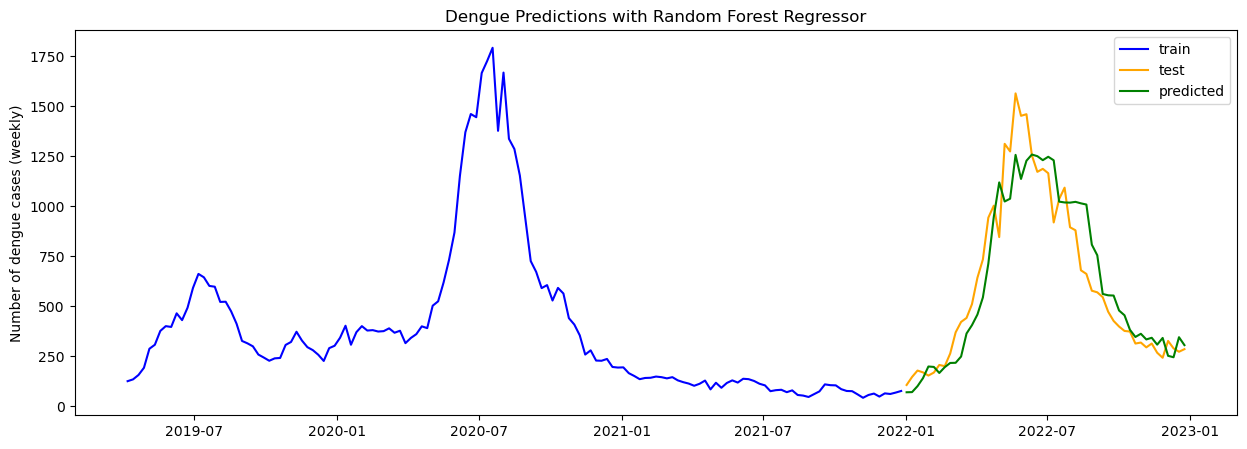

In [75]:
train_test_plot(train, test, results['preds_test'], title='Dengue Predictions with Random Forest Regressor')

#### Residual Plot

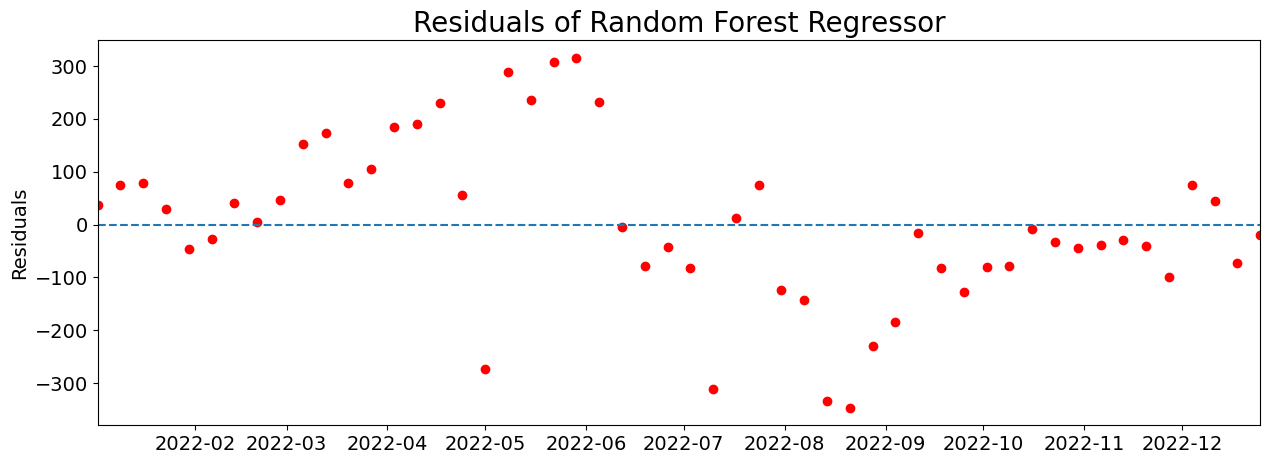

In [76]:
resid = plot_residuals(test['dengue_cases'], results['preds_test'].squeeze(), title='Residuals of Random Forest Regressor')

## Multi-step Forecasting

Picking the best single-step forecasting models (i.e. Gradient Boosting and Random Forest), we will attempt to build a multi-step forecasting model to enable stakeholders to have advanced warning of a potential dengue outbreak up to 4 weeks ahead.

### Final Model - 4-week Lookahead Model

We will use a combination of the best models to produce a X-week lookahead forecast of dengue cases, where X is the number of weeks determined by the user. We will also create a function to automatically choose the better model when fitting, so that this can be extended to further weeks ahead. This means:
| Week(s) Ahead | Model |
|-----|-----|
| 1 | Random Forest |
| 2 | Random Forest |
| 3 | Random Forest |
| 4 | Gradient Boosting |
| ... | ... |

For the purposes of this project, we will work on a 4-week lookahead model to provide NEA and MOH a lead time of 4 weeks to prepare for an anticipated spike in Dengue cases.

In [17]:
# define the types of models to choose from for each prediction step
model_list = {
    'rf': RandomForestRegressor(),
    'gb': GradientBoostingRegressor(),
    'sv': SVR()
}

In [18]:
# define search grid for hyperparameters
model_searchgrid = {
    'rf': {
           'n_estimators': [500, 800, 1000], 
           'max_features': [0.3, 0.5, 1.0],
           'max_depth': [10, 50, 70],
           'min_samples_split': [2, 5, 11, 19],
           'min_samples_leaf': [1, 3, 5, 7, 9],
          },
    'gb': {
           'n_estimators' : [50, 100, 150],
           'learning_rate' : [0.1, 0.05, 0.01],
           'max_depth' : [3, 5, 7],
           'min_samples_split' : [2, 5, 10],
           'min_samples_leaf' : [1, 2, 4],
           'max_features' : [5, 15, 25, 30]
          },
    'sv': {
           'kernel': ['rbf', 'linear'],
           #'C': [0.1, 1.0, 10, 100],
           #'epsilon': [0.1, 0.3, 0.5, 0.7, 1.0]
          }
}

In [18]:
# define the number of weeks lookahead
weeksahead = 4

In [19]:
# instantiate the custom model object
model_4wk_lookahead = DengueModel(model_list, searchgrid=model_searchgrid, weeks=weeksahead)

In [20]:
# drop any remaining NA values
dataset = data.dropna()

In [21]:
%%time
# fit model
model_4wk_lookahead.fit(dataset.drop(columns='dengue_cases'), dataset['dengue_cases'])

CPU times: total: 1min 4s
Wall time: 5h 51min 45s


In [37]:
# compute RMSE of model, note that the X variable has [:-weeksahead] to factor in that 
# the prediction is weeksahead steps into the future
model_4wk_lookahead.score(data.loc[data.index.year==2022, :].drop(columns='dengue_cases'), data.loc[data.index.year==2022, 'dengue_cases'])


19.81292369620227

In [36]:
model_4wk_lookahead = pickle.load(open('../models/model_4wk_lookahead.sav', 'rb'))

Observation:

- Overall performance of model is quite good for 4-week lookahead with RMSE at 20.

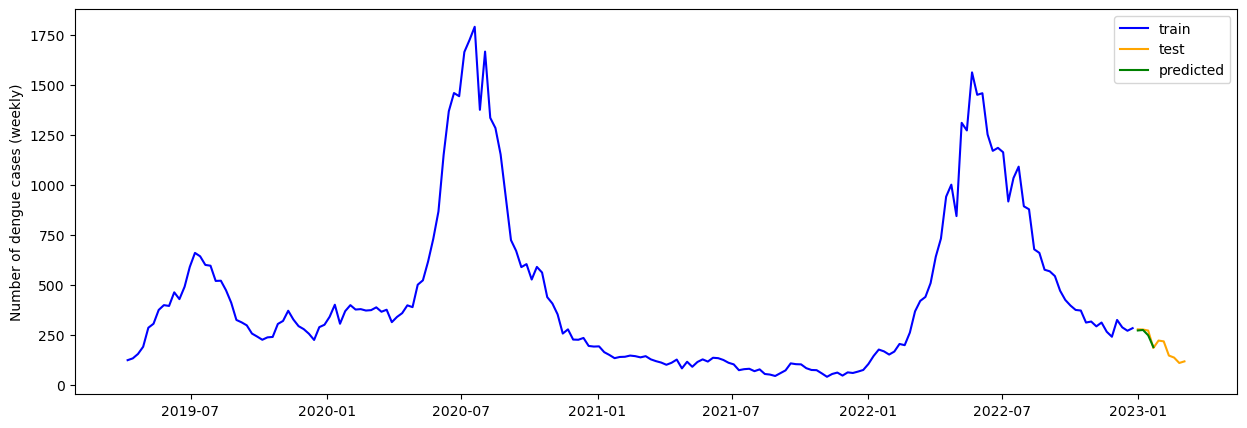

In [98]:
# try prediction and visualise effectiveness
start_point_data = data.loc[[get_date_index(52, 2022)],:].drop(columns='dengue_cases')
pred = model_4wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_4wk_lookahead.weeks+1, freq='W')[1:]

train_test_plot(data_subset[['dengue_cases']], data.loc[data.index.year==2023, ['dengue_cases']], pred)

### Extension: 8-week Lookahead Model

Using the same framework, we try out a 8-week lookahead model

In [48]:
# define the number of weeks lookahead
weeksahead = 8

In [49]:
# instantiate the custom model object
model_8wk_lookahead = DengueModel(model_list, searchgrid=model_searchgrid, weeks=weeksahead)

In [50]:
# drop any remaining NA values
dataset = data.dropna()

In [51]:
%%time
# fit model
model_8wk_lookahead.fit(dataset.drop(columns='dengue_cases'), dataset['dengue_cases'])

CPU times: total: 2min 17s
Wall time: 3h 34min 38s


In [34]:
# compute RMSE of model, note that the X variable has [:-weeksahead] to factor in that 
# the prediction is weeksahead steps into the future
model_8wk_lookahead.score(data.loc[data.index.year==2022, :].drop(columns='dengue_cases'), data.loc[data.index.year==2022, 'dengue_cases'])


32.46643493973138

In [35]:
# compute RMSE of model on test data, note that the X variable has [:-weeksahead] to factor in that 
# the prediction is weeksahead steps into the future
model_8wk_lookahead.score(data.loc[data.index.year==2023, :].drop(columns='dengue_cases'), data.loc[data.index.year==2023, 'dengue_cases'])


29.19877913571893

Observation:

- Overall performance of model is quite good for 8-week lookahead with RMSE at 32. It is marginally worse than the 4-week model.

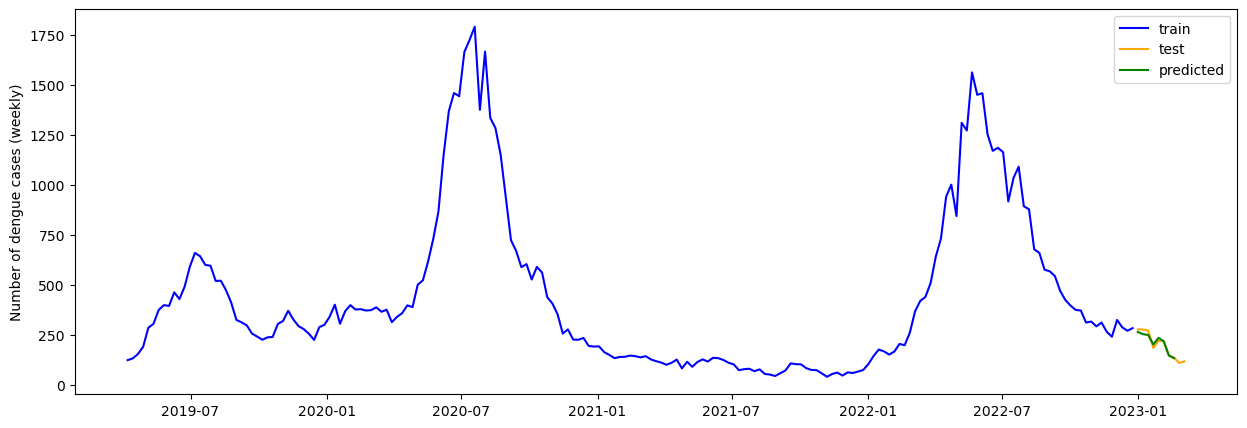

In [99]:
start_point_data = data.loc[[get_date_index(52, 2022)],:].drop(columns='dengue_cases')
pred = model_8wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_8wk_lookahead.weeks+1, freq='W')[1:]

train_test_plot(data_subset[['dengue_cases']], data.loc[data.index.year==2023, ['dengue_cases']], pred)

### Extension: 16-week Lookahead Model

Using the same framework, we try out a 16-week lookahead model

In [19]:
# define the number of weeks lookahead
weeksahead = 16

In [20]:
# instantiate the custom model object
model_16wk_lookahead = DengueModel(model_list, searchgrid=model_searchgrid, weeks=weeksahead)

In [21]:
# drop any remaining NA values
dataset = data.dropna()

In [22]:
%%time
# fit model
model_16wk_lookahead.fit(dataset.drop(columns='dengue_cases'), dataset['dengue_cases'])

Successfully fitted model for week 1.
Successfully fitted model for week 2.
Successfully fitted model for week 3.
Successfully fitted model for week 4.
Successfully fitted model for week 5.
Successfully fitted model for week 6.
Successfully fitted model for week 7.
Successfully fitted model for week 8.
Successfully fitted model for week 9.
Successfully fitted model for week 10.
Successfully fitted model for week 11.
Successfully fitted model for week 12.
Successfully fitted model for week 13.
Successfully fitted model for week 14.
Successfully fitted model for week 15.
Successfully fitted model for week 16.
CPU times: user 59 s, sys: 1.09 s, total: 1min
Wall time: 34min 41s


In [31]:
# compute RMSE of model, note that the X variable has [:-weeksahead] to factor in that 
# the prediction is weeksahead steps into the future
model_16wk_lookahead.score(data.loc[data.index.year==2022, :].drop(columns='dengue_cases'), data.loc[data.index.year==2022, 'dengue_cases'])


91.04200113920099

Observation:

- Overall performance of model is quite good for 16-week lookahead with RMSE at 91. It is very good.

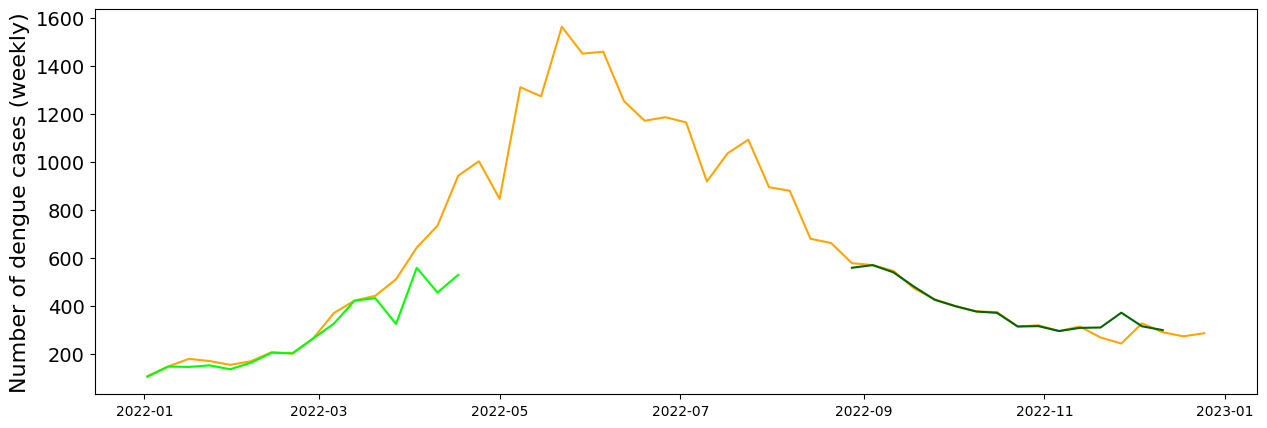

In [41]:
# plotting predictions on validation dataset for presentation

plt.figure(figsize=(15, 5))    
plt.plot(test[['dengue_cases']], c='orange')

# try week 52 of 2021
start_point_data = data.loc[[get_date_index(52, 2021)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

plt.plot(pred, c='lime')

# try week 17 of 2022
# start_point_data = data.loc[[get_date_index(17, 2022)],:].drop(columns='dengue_cases')
# pred = model_16wk_lookahead.predict(start_point_data).T
# pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

# plt.plot(pred, c='forestgreen')

# try week 34 of 2022
start_point_data = data.loc[[get_date_index(34, 2022)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

plt.plot(pred, c='darkgreen')

plt.ylabel('Number of dengue cases (weekly)', fontsize=16, family)
plt.yticks(fontsize=14)

plt.show()

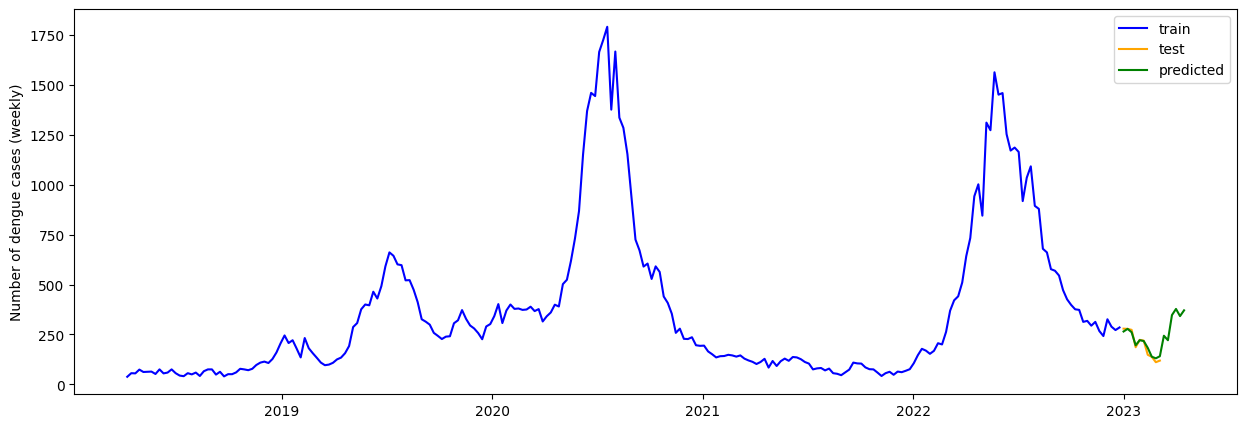

In [28]:
start_point_data = data.loc[[get_date_index(52, 2022)],:].drop(columns='dengue_cases')
pred = model_16wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_16wk_lookahead.weeks+1, freq='W')[1:]

train_test_plot(data_subset[['dengue_cases']], data.loc[data.index.year==2023, ['dengue_cases']], pred)

### Extension: 52-week Lookahead Model

Using the same framework, we try out a 52-week lookahead model

In [19]:
# define the number of weeks lookahead
weeksahead = 52

In [20]:
# instantiate the custom model object
model_52wk_lookahead = DengueModel(model_list, searchgrid=model_searchgrid, weeks=weeksahead)

In [21]:
# drop any remaining NA values
dataset = data.dropna()

In [22]:
%%time
# fit model
model_52wk_lookahead.fit(dataset.drop(columns='dengue_cases'), dataset['dengue_cases'])

Successfully fitted model for week 1.
Successfully fitted model for week 2.
Successfully fitted model for week 3.
Successfully fitted model for week 4.
Successfully fitted model for week 5.
Successfully fitted model for week 6.
Successfully fitted model for week 7.
Successfully fitted model for week 8.
Successfully fitted model for week 9.
Successfully fitted model for week 10.
Successfully fitted model for week 11.
Successfully fitted model for week 12.
Successfully fitted model for week 13.
Successfully fitted model for week 14.
Successfully fitted model for week 15.
Successfully fitted model for week 16.
Successfully fitted model for week 17.
Successfully fitted model for week 18.
Successfully fitted model for week 19.
Successfully fitted model for week 20.
Successfully fitted model for week 21.
Successfully fitted model for week 22.
Successfully fitted model for week 23.
Successfully fitted model for week 24.
Successfully fitted model for week 25.
Successfully fitted model for week

In [ ]:
# compute RMSE of model, note that the X variable has [:-weeksahead] to factor in that 
# the prediction is weeksahead steps into the future
test_special = pd.concat([test, data.loc[[get_date_index(1,2023)], :]], axis=0)
model_52wk_lookahead.score(test_special.drop(columns='dengue_cases'), test_special['dengue_cases'])


Observation:

- Overall performance of model is quite good for 16-week lookahead with RMSE at 128. It is marginally worse than the 4-week model.

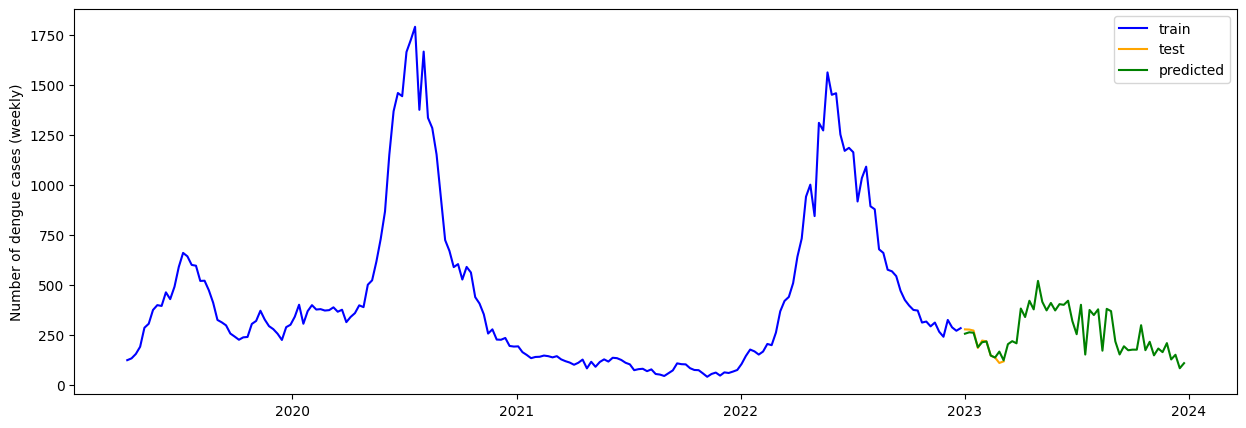

In [25]:
start_point_data = data.loc[[get_date_index(52, 2022)],:].drop(columns='dengue_cases')
pred = model_52wk_lookahead.predict(start_point_data).T
pred.index = pd.date_range(start=start_point_data.index[0], periods=model_52wk_lookahead.weeks+1, freq='W')[1:]

train_test_plot(data_subset[['dengue_cases']], data.loc[data.index.year==2023, ['dengue_cases']], pred)

#### Save Models

In [76]:
# 4-week model
pickle.dump(model_4wk_lookahead, open('../models/model_4wk_lookahead.sav', 'wb'))
# 8-week model
pickle.dump(model_8wk_lookahead, open('../models/model_8wk_lookahead.sav', 'wb'))

In [23]:
# 16-week model
pickle.dump(model_16wk_lookahead, open('../models/model_16wk_lookahead.sav', 'wb'))


In [24]:
# 52-week model
pickle.dump(model_52wk_lookahead, open('../models/model_52wk_lookahead.sav', 'wb'))


In [ ]:
# Install pmdarina at your own risk. It casues a lot of issues with the dependencies. 
from pmdarima.arima import auto_arima

In [ ]:
model_auto = auto_arima(train['dengue_cases'], exogenous=train.drop(columns=['dengue_cases']), 
                       trace=True, error_action='ignore', suppress_warnings=True)

In [ ]:
# Instantiate best model.
arimax = ARIMA(endog=train['dengue_cases'], order=(1, 1, 2), 
               exog=train.drop(columns=['dengue_cases']))

# Fit ARIMA model.
model_2 = arimax.fit()

# Generate predictions based on test set.
#preds = model.predict(start=test.index[0], end = test.index[-1])
# Start at 196 instead of 195 because we took difference = 1
#preds = model.predict(start=196, end=257)
preds_auto = model_2.predict(start=196, end=256, exog=test.drop(columns=['dengue_cases']))

In [ ]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds_auto, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();